## Importing necessary Libraries and Dataset 

In [3]:
# importing necessary libraries
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats
from matplotlib import rcParams
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [4]:
# Reading the Dataset 

data = pd.read_csv(r"C:\Users\IceCandyman\Desktop\Tools and Techiniques\Tools and Technique project\cardio_train.csv", sep=";")


In [5]:
# Getting data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
# Getting preview of the data

data.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

## Feature Engineering and Tuning

In [7]:
# Calculate the BMI using weight and height columns
data["bmi"] = data["weight"] / (data["height"] / 100) ** 2

#Convert age from days to years
data['age'] = (data['age'] / 365).round().astype('int')

# Filter out rows based on conditions for 'ap_hi' and 'ap_lo'
out_filter = (data["ap_hi"] > 250) | (data["ap_lo"] > 200)
data = data[~out_filter]

# Define the filter condition for 'ap_hi' and 'ap_lo' values less than 0
out_filter_negative = (data["ap_hi"] < 0) | (data["ap_lo"] < 0)

# Filter the dataframe to retain rows where neither 'ap_hi' nor 'ap_lo' is less than 0
data = data[~out_filter_negative]

In [8]:
# Drop the 'id' column from the dataframe
data.drop(columns="id", inplace=True)

# Drop the irrelevent features for Logistic Regression from dataset
#data.drop(columns=['smoke', 'height','active','gluc','gender','alco'], inplace=True)

# Drop the irrelevent features for Decision Tree from dataset
#data.drop(columns=['smoke', 'weight','active','gluc','gender','alco'], inplace=True)

# Remove duplicate rows from the dataframe
data.drop_duplicates(inplace=True)




# Print the length of the filtered dataframe
print(len(data))


65183


## EDA

In [9]:
# To see how many patients have diastilic pressure higher than systolic pressure.
print("Diastilic pressure is higher than systolic one in {0} cases".format(data[data['ap_lo']> data['ap_hi']].shape[0]))



Diastilic pressure is higher than systolic one in 273 cases


In [10]:
# Diastilic pressure can not be higher than systolic pressure.
data.drop(data[(data['ap_hi'] > data['ap_hi'].quantile(0.975)) | (data['ap_hi'] < data['ap_hi'].quantile(0.025))].index, inplace=True)
data.drop(data[(data['ap_lo'] > data['ap_lo'].quantile(0.975)) | (data['ap_lo'] < data['ap_lo'].quantile(0.025))].index, inplace=True)


In [11]:
print(len(data))


61816


In [12]:
# To check mean,median, std , min, and max of data
data.describe()

age        gender        height        weight         ap_hi  \
count  61816.000000  61816.000000  61816.000000  61816.000000  61816.000000   
mean      53.359438      1.357804    164.417966     74.408558    126.212421   
std        6.806037      0.479358      8.302063     14.295604     14.216281   
min       30.000000      1.000000     55.000000     11.000000    100.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       54.000000      1.000000    165.000000     72.000000    120.000000   
75%       59.000000      2.000000    170.000000     82.000000    140.000000   
max       65.000000      2.000000    250.000000    200.000000    165.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  61816.000000  61816.000000  61816.000000  61816.000000  61816.000000   
mean      81.168063      1.378316      1.235570      0.092419      0.055762   
std        8.524832      0.688293      0.582964      0.289619      0.229464   
min       60.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      100.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio           bmi  
count  61816.000000  61816.000000  61816.000000  
mean       0.797043      0.503785     27.616297  
std        0.402204      0.499990      6.089516  
min        0.000000      0.000000      3.471784  
25%        1.000000      0.000000     23.875115  
50%        1.000000      1.000000     26.562500  
75%        1.000000      1.000000     30.421850  
max        1.000000      1.000000    298.666667

In [13]:
# Count missing values for each column
missing_count = data.isnull().sum()
print("\nCount of missing values for each column:")
print(missing_count)


Count of missing values for each column:
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
bmi            0
dtype: int64


In [14]:
# Getting preview of data
data.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   48       1     156    56.0    100     60            1     1      0     0   

   active  cardio        bmi  
0       1       0  21.967120  
1       1       1  34.927679  
2       0       1  23.507805  
3       1       1  28.710479  
4       0       0  23.011177

In [15]:
# Getting data info again to see how the data has changed
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 61816 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          61816 non-null  int32  
 1   gender       61816 non-null  int64  
 2   height       61816 non-null  int64  
 3   weight       61816 non-null  float64
 4   ap_hi        61816 non-null  int64  
 5   ap_lo        61816 non-null  int64  
 6   cholesterol  61816 non-null  int64  
 7   gluc         61816 non-null  int64  
 8   smoke        61816 non-null  int64  
 9   alco         61816 non-null  int64  
 10  active       61816 non-null  int64  
 11  cardio       61816 non-null  int64  
 12  bmi          61816 non-null  float64
dtypes: float64(2), int32(1), int64(10)
memory usage: 6.4 MB


In [16]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers_iqr

def detect_outliers_zscore(data):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outliers_zscore = (abs_z_scores > 3)  # Threshold can be adjusted; 3 is a common threshold
    return outliers_zscore



# Detect outliers using both methods
outliers_iqr = detect_outliers_iqr(data)
outliers_zscore = detect_outliers_zscore(data)

# Find overlapping outliers by merging the two outlier detection results
overlapping_outliers = outliers_iqr & outliers_zscore

# Display rows where both methods detect outliers
print("Overlapping outliers detected by both IQR and Z-score methods:")
print(data[overlapping_outliers.any(axis=1)])


Overlapping outliers detected by both IQR and Z-score methods:
       age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
7       62       2     178    95.0    130     90            3     3      0   
14      40       2     181    95.0    130     90            1     1      1   
17      46       1     158    52.0    110     70            1     3      0   
19      60       2     162    56.0    120     70            1     1      1   
29      58       2     169    74.0    130     70            1     3      0   
...    ...     ...     ...     ...    ...    ...          ...   ...    ...   
69970   62       2     173   103.0    140     80            3     1      1   
69980   49       2     167    69.0    110     80            1     1      0   
69985   50       1     156   102.0    130     80            1     1      0   
69995   53       2     168    76.0    120     80            1     1      1   
69996   62       1     158   126.0    140     90            2     2      0   



In [17]:
# Count the number of overlapping outliers
count_overlapping_outliers = overlapping_outliers.sum().sum()  # Summing twice to get a single count

print("Count of overlapping outliers detected by both IQR and Z-score methods:", count_overlapping_outliers)


Count of overlapping outliers detected by both IQR and Z-score methods: 15356


In [18]:
# Remove overlapping outliers from the DataFrame
data = data[~overlapping_outliers.any(axis=1)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49283 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          49283 non-null  int32  
 1   gender       49283 non-null  int64  
 2   height       49283 non-null  int64  
 3   weight       49283 non-null  float64
 4   ap_hi        49283 non-null  int64  
 5   ap_lo        49283 non-null  int64  
 6   cholesterol  49283 non-null  int64  
 7   gluc         49283 non-null  int64  
 8   smoke        49283 non-null  int64  
 9   alco         49283 non-null  int64  
 10  active       49283 non-null  int64  
 11  cardio       49283 non-null  int64  
 12  bmi          49283 non-null  float64
dtypes: float64(2), int32(1), int64(10)
memory usage: 5.1 MB


In [19]:
# To see the changes in summary statistic of data after removing outliers
data.describe()

age        gender        height        weight         ap_hi  \
count  49283.000000  49283.000000  49283.000000  49283.000000  49283.000000   
mean      53.300996      1.302822    163.963131     73.249336    125.773695   
std        6.820117      0.459484      7.692969     13.036323     14.202804   
min       39.000000      1.000000    140.000000     32.000000    100.000000   
25%       48.000000      1.000000    158.000000     64.000000    120.000000   
50%       54.000000      1.000000    164.000000     72.000000    120.000000   
75%       58.000000      2.000000    169.000000     81.000000    140.000000   
max       65.000000      2.000000    189.000000    117.000000    165.000000   

              ap_lo   cholesterol          gluc    smoke     alco  \
count  49283.000000  49283.000000  49283.000000  49283.0  49283.0   
mean      80.939127      1.283830      1.079135      0.0      0.0   
std        8.522830      0.588497      0.269952      0.0      0.0   
min       60.000000      1.000000      1.000000      0.0      0.0   
25%       80.000000      1.000000      1.000000      0.0      0.0   
50%       80.000000      1.000000      1.000000      0.0      0.0   
75%       90.000000      1.000000      1.000000      0.0      0.0   
max      100.000000      3.000000      2.000000      0.0      0.0   

             active        cardio           bmi  
count  49283.000000  49283.000000  49283.000000  
mean       0.791287      0.497677     27.285959  
std        0.406393      0.500000      4.814813  
min        0.000000      0.000000     12.254473  
25%        1.000000      0.000000     23.875115  
50%        1.000000      0.000000     26.370238  
75%        1.000000      1.000000     30.102119  
max        1.000000      1.000000     45.879501

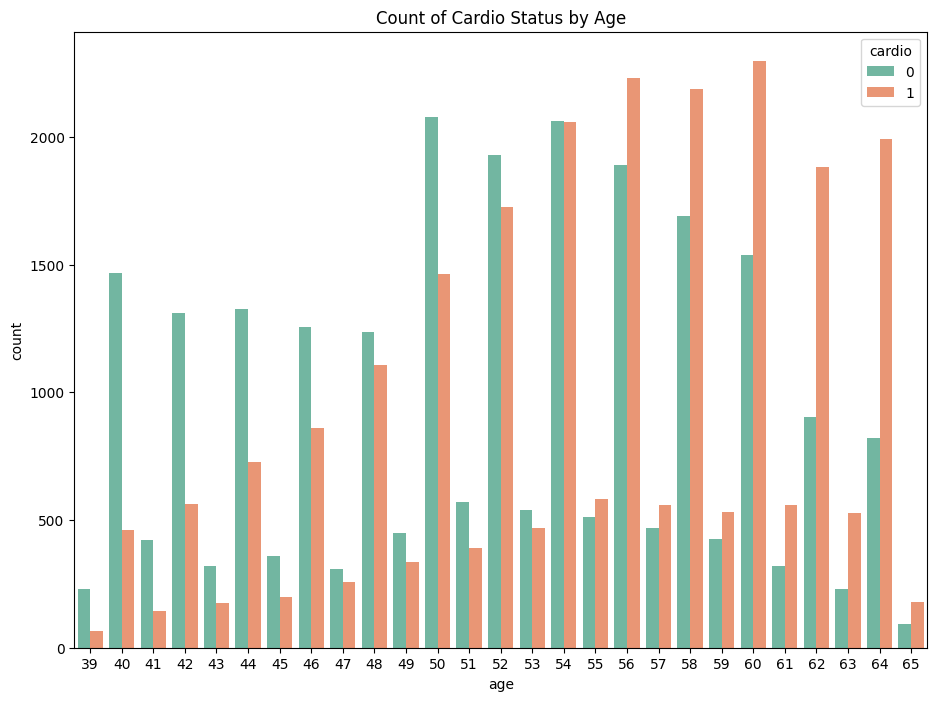

In [20]:
# Age wise comparison of Cardio

# Set the figure size using rcParams
rcParams['figure.figsize'] = 11, 8

# Create the countplot
sns.countplot(x='age', hue='cardio', data=data, palette="Set2")

# Add title to the plot
plt.title('Count of Cardio Status by Age')

# Display the plot
plt.show()


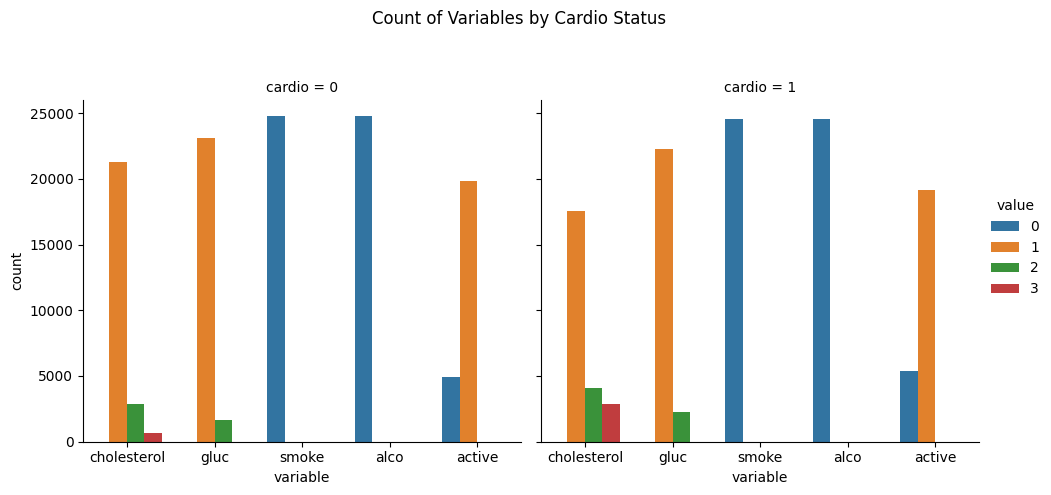

In [21]:
# Comparison of Variables by Cardio 

# Melt the dataframe to long format
df_long = pd.melt(data, id_vars=['cardio'], value_vars=['cholesterol', 'gluc', 'smoke', 'alco', 'active'])

# Create the catplot
sns.catplot(x="variable", hue="value", col="cardio", data=df_long, kind="count")

# Add title to the plot
plt.subplots_adjust(top=0.8)  # Adjust the plot to make room for the title
plt.suptitle('Count of Variables by Cardio Status')  # Set the title above the plot

# Display the plot
plt.show()


Diastilic pressure is higher than systolic one in 0 cases


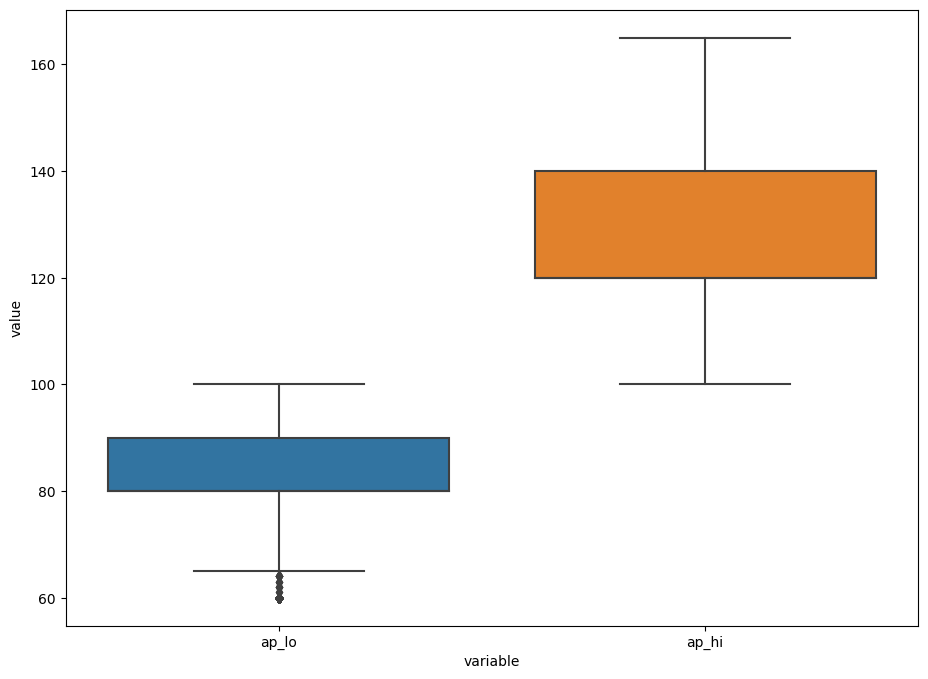

In [22]:
blood_pressure = data.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(data[data['ap_lo']> data['ap_hi']].shape[0]))

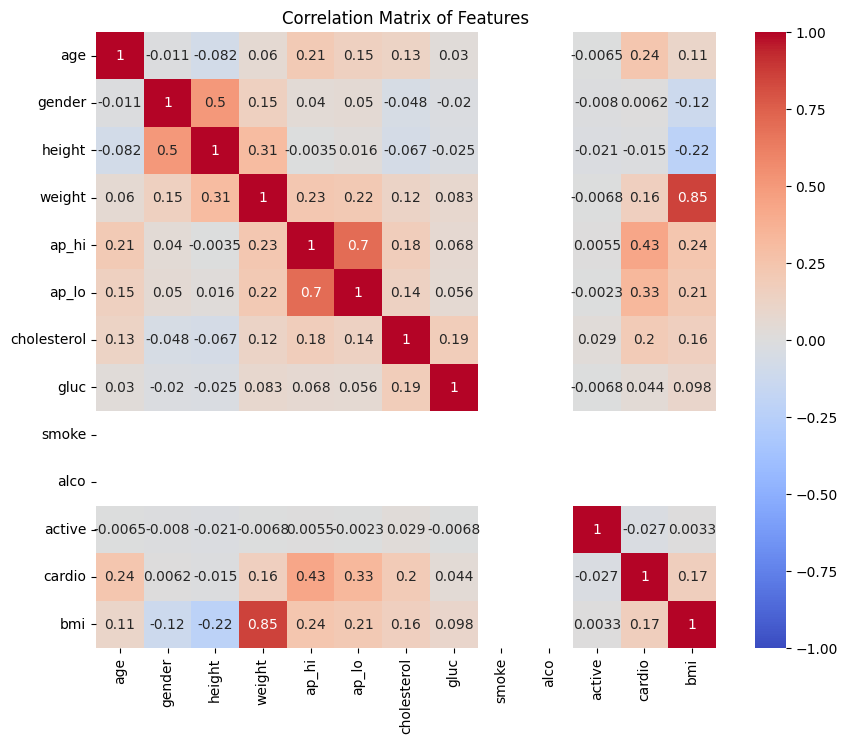

In [23]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()


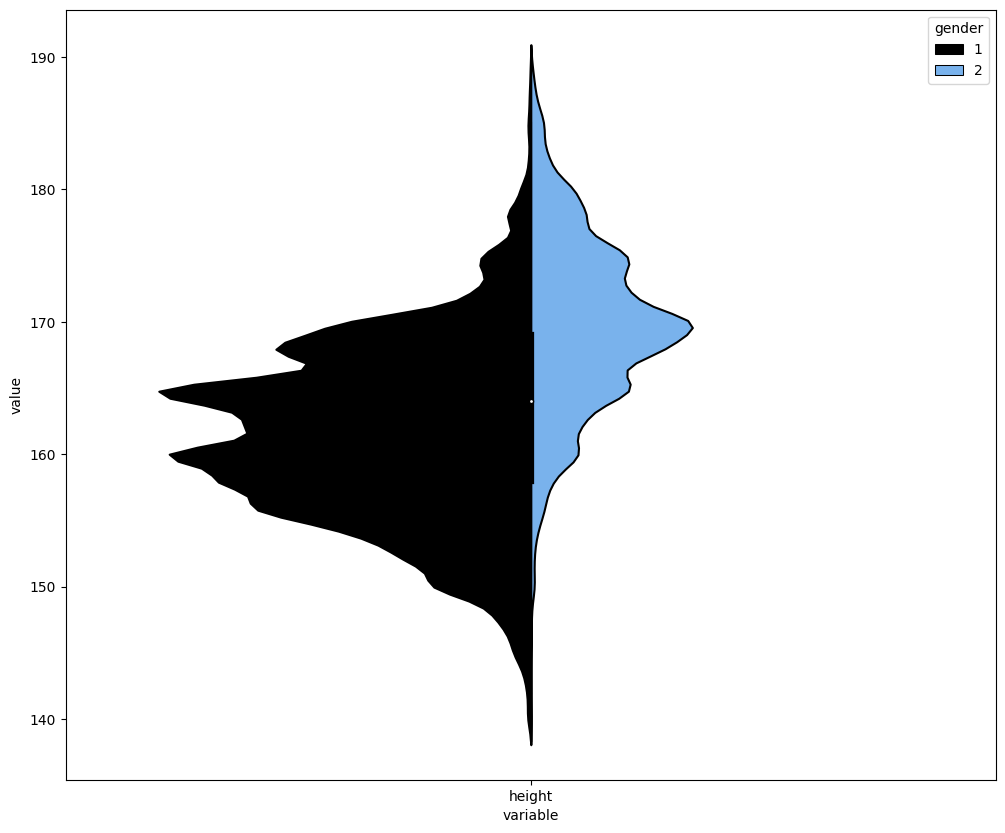

In [24]:
# Comparing heights of Male and female. From here it can be confirmed that 1 represent Female and 2 represents Male
import warnings

# Ignore warnings for better presentation
warnings.filterwarnings("ignore")

# Melt the dataframe to long format
df_melt = pd.melt(frame=data, value_vars=['height'], id_vars=['gender'])

# Set the figure size
plt.figure(figsize=(12, 10))

# Define custom colors
custom_palette = ["#000000", "#66B2FF"]  # You can add more colors if needed

# Create the violin plot with custom colors
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    split=True, 
    data=df_melt, 
    scale='count',
    scale_hue=False,
    palette=custom_palette
)

# Display the plot
plt.show()


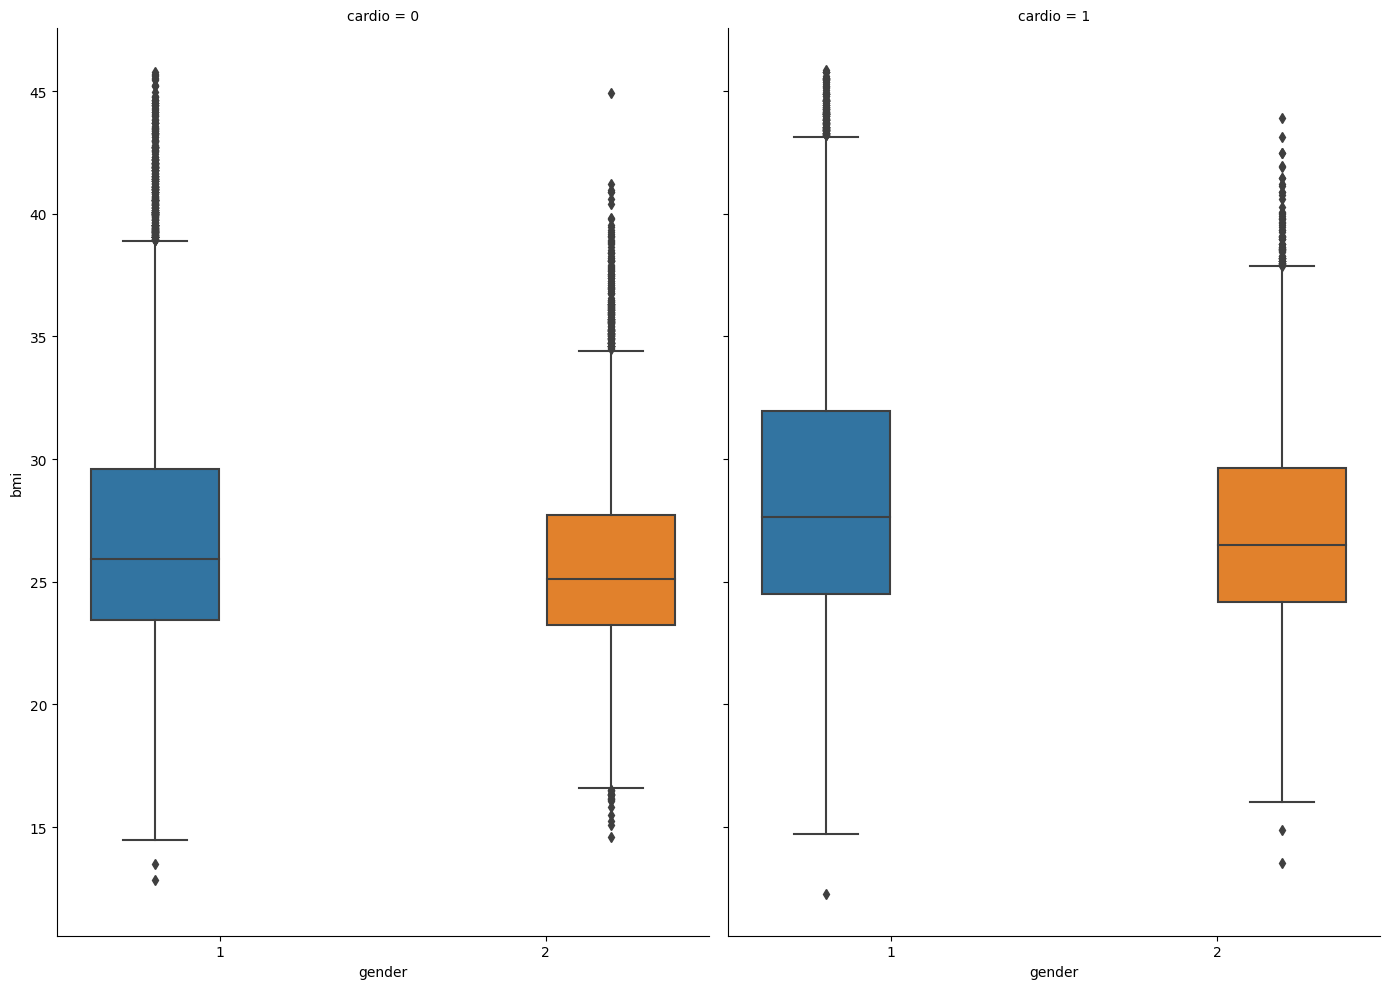

In [25]:
# Compare average BMI for healthy people to average BMI of ill people. Normal BMI values are said to be from 18.5 to 25.

sns.catplot(
    x="gender", 
    y="bmi", 
    hue="gender", 
    col="cardio", 
    data=data,
    kind="box", 
    height=10, 
    aspect=.7
)



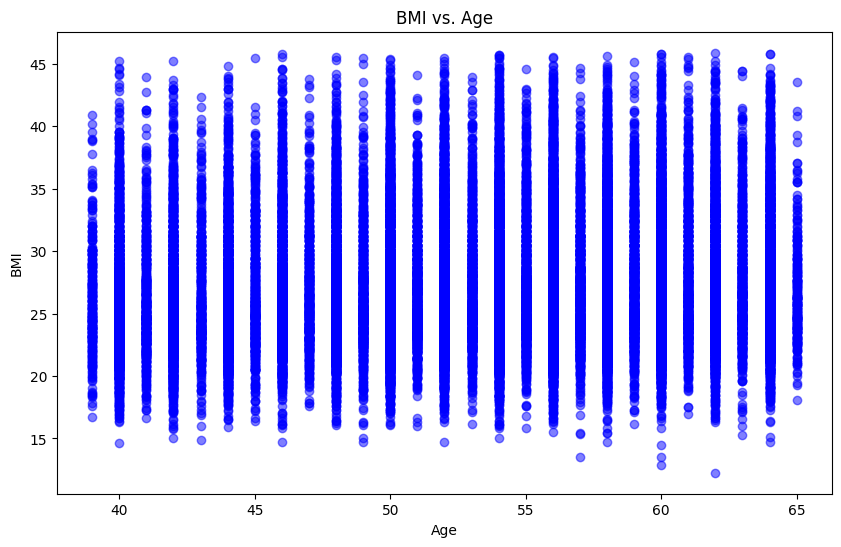

In [26]:
# Create a scatter plot comparing BMI with age
plt.figure(figsize=(10, 6))
plt.scatter(data['age'], data['bmi'], alpha=0.5, color='blue')  # Adjust alpha for transparency if needed

# Add title and labels
plt.title('BMI vs. Age')
plt.xlabel('Age')
plt.ylabel('BMI')

# Display grid
plt.grid(False)

# Show the plot
plt.show()


In [16]:
# Generate the profile report
profile = data.profile_report(title="data")

# Save the report as an HTML file
profile.to_file("data_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\multimethod\__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

  # Preparation for Model 

In [27]:
# Define the target column name
target_column = 'cardio'

# Extract the target column data and store it in a separate variable
target_data = data[target_column]

# Drop the target column from the DataFrame
data.drop(columns=[target_column], inplace=True)


In [28]:
# Splitting the dataset and target variable into training and test sets
train_data, test_data, train_target, test_target = train_test_split(data, target_data, test_size=0.2, random_state=0)


In [29]:
# Splitting the train_data and train_target into training and validation sets
train_data, val_data, train_target, val_target = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

# Here, we've used test_size=0.20 to allocate 20% of the original train_data to the validation set


In [30]:
train_data.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
62617   46       1     156    65.0    110     70            1     1      0   
17094   44       1     158    80.0    140     90            1     1      0   
63439   46       2     175    96.0    130     90            2     1      0   
30704   46       1     160    60.0    120     80            1     1      0   
63312   50       2     183    84.0    130     80            1     1      0   

       alco  active        bmi  
62617     0       1  26.709402  
17094     0       1  32.046146  
63439     0       1  31.346939  
30704     0       1  23.437500  
63312     0       1  25.082863

In [31]:
test_data.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
67270   44       1     163    66.0    100     60            1     1      0   
24458   57       1     170    66.0    110     60            1     1      0   
69455   59       2     165    79.0    160    100            1     2      0   
15652   42       1     164    85.0    140     90            2     1      0   
1524    58       1     168    80.0    120     70            1     1      0   

       alco  active        bmi  
67270     0       1  24.840980  
24458     0       1  22.837370  
69455     0       1  29.017447  
15652     0       1  31.603212  
1524      0       0  28.344671

In [32]:
val_data.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
26590   54       1     167    66.0    120     80            1     1      0   
66783   44       1     168    51.0    120     80            1     1      0   
10490   64       2     169    68.0    120     70            1     1      0   
66683   54       2     163    83.0    120     80            1     1      0   
59500   52       1     165    65.0    150     90            1     1      0   

       alco  active        bmi  
26590     0       1  23.665244  
66783     0       1  18.069728  
10490     0       0  23.808690  
66683     0       1  31.239414  
59500     0       1  23.875115

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9857 entries, 67270 to 22218
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          9857 non-null   int32  
 1   gender       9857 non-null   int64  
 2   height       9857 non-null   int64  
 3   weight       9857 non-null   float64
 4   ap_hi        9857 non-null   int64  
 5   ap_lo        9857 non-null   int64  
 6   cholesterol  9857 non-null   int64  
 7   gluc         9857 non-null   int64  
 8   smoke        9857 non-null   int64  
 9   alco         9857 non-null   int64  
 10  active       9857 non-null   int64  
 11  bmi          9857 non-null   float64
dtypes: float64(2), int32(1), int64(9)
memory usage: 962.6 KB


## Logistic Regression

In [34]:
# Define a range of C values to evaluate
c_values = [0.001, 0.01, 0.1, 1, 10, 100]  # you can adjust this range based on your requirements

best_f1 = 0
best_c = None

# Iterate over each C value and perform cross-validation
for c in c_values:
    logreg1 = LogisticRegression(C=c, max_iter=10000)  # Increase max_iter for convergence
    cv_scores = cross_val_score(logreg1, val_data, val_target, cv=5, scoring='f1')
    
    # Compute the mean F1 score across cross-validation folds
    mean_f1 = np.mean(cv_scores)
    
    # Update the best C value if a better F1 score is found
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_c = c

print(f"Best C value: {best_c}")
print(f"Best F1 score: {best_f1:.2f}")

# Train the logistic regression model using the best C value
logreg = LogisticRegression(C=best_c, max_iter=10000)
logreg.fit(train_data, train_target)

# Predict on the test set
y_pred = logreg.predict(test_data)

# Calculate the F1 score on the test set
test_f1 = f1_score(test_target, y_pred)
print(f"F1 Score on test set using best C: {test_f1:.2f}")

# Make predictions on the training set
train_predictions1 = logreg.predict(train_data)
train_probabilities1 = logreg.predict_proba(train_data)[:, 1]

# Make predictions on the test set
test_predictions1 = logreg.predict(test_data)
test_probabilities1 = logreg.predict_proba(test_data)[:, 1]

# Calculate and round the accuracy of the model on the training set
accuracy_train = round(accuracy_score(train_target, train_predictions1) * 100, 2)

# Calculate and round the accuracy of the model on the test set
accuracy_test = round(accuracy_score(test_target, test_predictions1) * 100, 2)

# Calculate other evaluation metrics on the training set
conf_matrix_train = confusion_matrix(train_target, train_predictions1)
class_rep_train = classification_report(train_target, train_predictions1)
roc_auc_train = roc_auc_score(train_target, train_probabilities1)

# Calculate other evaluation metrics on the test set
conf_matrix_test = confusion_matrix(test_target, test_predictions1)
class_rep_test = classification_report(test_target, test_predictions1)
roc_auc_test = roc_auc_score(test_target, test_probabilities1)

# Display the evaluation metrics
print(f"Accuracy on the training set: {accuracy_train}%")
print(f"Confusion Matrix on training set:\n{conf_matrix_train}")
print(f"Classification Report on training set:\n{class_rep_train}")
print(f"ROC AUC Score on training set: {roc_auc_train:.2f}")

print(f"\nAccuracy on the test set: {accuracy_test}%")
print(f"Confusion Matrix on test set:\n{conf_matrix_test}")
print(f"Classification Report on test set:\n{class_rep_test}")
print(f"ROC AUC Score on test set: {roc_auc_test:.2f}")


Best C value: 0.001
Best F1 score: 0.70
F1 Score on test set using best C: 0.70
Accuracy on the training set: 71.4%
Confusion Matrix on training set:
[[12124  3679]
 [ 5340 10397]]
Classification Report on training set:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     15803
           1       0.74      0.66      0.70     15737

    accuracy                           0.71     31540
   macro avg       0.72      0.71      0.71     31540
weighted avg       0.72      0.71      0.71     31540

ROC AUC Score on training set: 0.78

Accuracy on the test set: 71.66%
Confusion Matrix on test set:
[[3813 1160]
 [1633 3251]]
Classification Report on test set:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4973
           1       0.74      0.67      0.70      4884

    accuracy                           0.72      9857
   macro avg       0.72      0.72      0.72      9857
weighted avg       

## Decision Tree Classifier

The best depth is 5 with a mean cross-validation score of 0.72


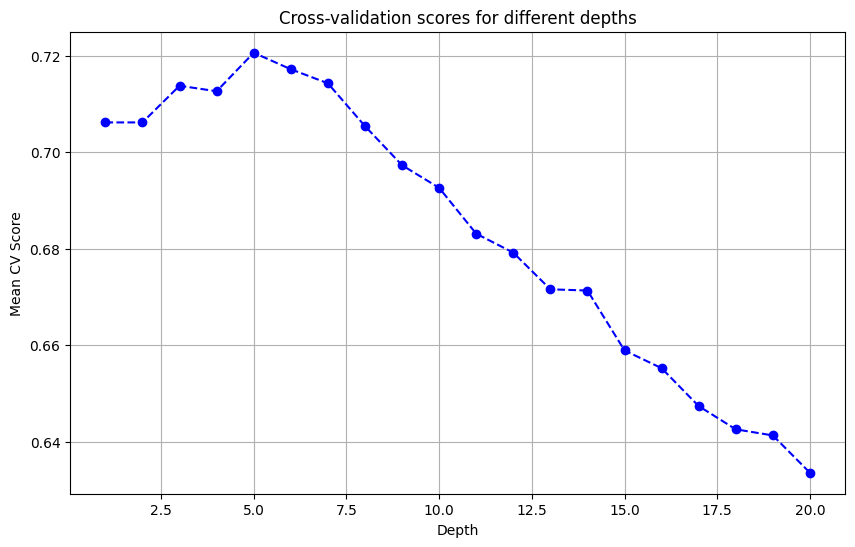

In [35]:
# To find best depth for our Decision Tree

# Splitting the dataset into features (X) and target (y)
#X = train_data 
#y = train_target


# Define a range of depths to evaluate
depths = np.arange(1, 21)  # This will evaluate depths from 1 to 20

# Store the mean cross-validation scores for each depth
cv_scores = []

# Loop over each depth value and compute the cross-validation score
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, val_data, val_target, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

# Find the depth that gives the highest cross-validation score
best_depth = depths[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"The best depth is {best_depth} with a mean cross-validation score of {best_score:.2f}")

# Optionally, you can visualize the cross-validation scores to see how they change with depth
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(depths, cv_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Depth')
plt.ylabel('Mean CV Score')
plt.title('Cross-validation scores for different depths')
plt.grid(True)
plt.show()


In [36]:
# Initialize the Decision Tree Classifier with specific hyperparameters
clf = DecisionTreeClassifier(max_depth=5, random_state=42 )

# Fit the model using the training data and target
clf.fit(train_data, train_target)

# Make predictions on the training set
train_predictions = clf.predict(train_data)
train_probabilities = clf.predict_proba(train_data)[:, 1]

# Make predictions on the test set
test_predictions = clf.predict(test_data)
test_probabilities = clf.predict_proba(test_data)[:, 1]

# Calculate and round the accuracy of the model on the training set
accuracy_train = round(accuracy_score(train_target, train_predictions) * 100, 2)

# Calculate and round the accuracy of the model on the test set
accuracy_test = round(accuracy_score(test_target, test_predictions) * 100, 2)

# Calculate other evaluation metrics on the training set
conf_matrix_train = confusion_matrix(train_target, train_predictions)
class_rep_train = classification_report(train_target, train_predictions)
roc_auc_train = roc_auc_score(train_target, train_probabilities)

# Calculate other evaluation metrics on the test set
conf_matrix_test = confusion_matrix(test_target, test_predictions)
class_rep_test = classification_report(test_target, test_predictions)
roc_auc_test = roc_auc_score(test_target, test_probabilities)

# Display the evaluation metrics
print(f"Accuracy on the training set: {accuracy_train}%")
print(f"Confusion Matrix on training set:\n{conf_matrix_train}")
print(f"Classification Report on training set:\n{class_rep_train}")
print(f"ROC AUC Score on training set: {roc_auc_train:.2f}")

print(f"\nAccuracy on the test set: {accuracy_test}%")
print(f"Confusion Matrix on test set:\n{conf_matrix_test}")
print(f"Classification Report on test set:\n{class_rep_test}")
print(f"ROC AUC Score on test set: {roc_auc_test:.2f}")


Accuracy on the training set: 72.18%
Confusion Matrix on training set:
[[12409  3394]
 [ 5382 10355]]
Classification Report on training set:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74     15803
           1       0.75      0.66      0.70     15737

    accuracy                           0.72     31540
   macro avg       0.73      0.72      0.72     31540
weighted avg       0.73      0.72      0.72     31540

ROC AUC Score on training set: 0.78

Accuracy on the test set: 72.31%
Confusion Matrix on test set:
[[3867 1106]
 [1623 3261]]
Classification Report on test set:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4973
           1       0.75      0.67      0.71      4884

    accuracy                           0.72      9857
   macro avg       0.73      0.72      0.72      9857
weighted avg       0.73      0.72      0.72      9857

ROC AUC Score on test set: 0.79


In [40]:
# Determine the maximum depth of the decision tree
max_depth = clf.tree_.max_depth


print(f"\nMaximum depth of the decision tree: {max_depth}")
# Feature importance
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index=train_data.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Maximum depth of the decision tree: 5

Feature Importances:
             Importance
ap_hi          0.781637
age            0.129388
cholesterol    0.075313
ap_lo          0.005591
bmi            0.004527
height         0.002466
weight         0.001078
gender         0.000000
gluc           0.000000
smoke          0.000000
alco           0.000000
active         0.000000


In [44]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

# Assuming clf is your trained decision tree classifier and feature_cols contains the names of your features
# If you have feature_cols defined, you can use it; otherwise, get the column names from your data frame.

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=train_data.columns,  # Replace with your actual feature names
                class_names=['0', '1'])     # Replace with your class names if different

# Create a PyDotPlus graph from the dot data
pydot_graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Set a larger figure size for better resolution
pydot_graph.set_size('"40,40!"')

# Increase DPI for better quality
pydot_graph.set_dpi(600)

# Write the decision tree to a PNG file
pydot_graph.write_png('decision_tree.png')

# Display the image
Image('decision_tree.png')


# MORE  ALGORITHMS 

## SVM

In [55]:
from sklearn.svm import SVC

# Initialize the Support Vector Machines model
svc = SVC()

# Fit the model using the training data and target
svc.fit(train_data, train_target)

# Calculate and round the accuracy of the model on the training set
accuracy_svc = round(svc.score(train_data, train_target) * 100, 2)

# Display the accuracy
print(f"Accuracy of Support Vector Machines on the training set: {accuracy_svc}%")


Accuracy of Support Vector Machines on the training set: 70.86%


In [56]:
# Calculate and round the accuracy of the SVM model on the test set
accuracy_test_svc = round(svc.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy of Support Vector Machines on the test set: {accuracy_test_svc}%")


Accuracy of Support Vector Machines on the test set: 71.32%


## Linear SVC

In [45]:
from sklearn.svm import LinearSVC

# Initialize the Linear SVC model with dual=False (assuming n_samples > n_features)
linear_svc = LinearSVC(dual=False)

# Fit the model using the training data and target
linear_svc.fit(train_data, train_target)

# Calculate and round the accuracy of the model on the training set
accuracy_linear_svc = round(linear_svc.score(train_data, train_target) * 100, 2)

# Display the accuracy on the training set
print(f"Accuracy of Linear SVC on the training set: {accuracy_linear_svc}%")


Accuracy of Linear SVC on the training set: 71.56%


In [46]:
# Calculate and round the accuracy of the Linear SVC model on the test set
accuracy_test_linear_svc = round(linear_svc.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy of Linear SVC on the test set: {accuracy_test_linear_svc}%")


Accuracy of Linear SVC on the test set: 71.82%


##  k-Nearest Neighbors algorithm


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {'n_neighbors': [2, 3,5,7]}

# Initialize and fit the KNN model using GridSearchCV
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=10)
knn.fit(train_data, train_target)

# Calculate and round the accuracy of the model on the training set
accuracy_knn = round(knn.score(train_data, train_target) * 100, 2)

# Display the accuracy and best parameters
print(f"Accuracy of KNN on the training set: {accuracy_knn}%")
print(f"Best parameters: {knn.best_params_}")


Accuracy of KNN on the training set: 75.49%
Best parameters: {'n_neighbors': 7}


In [48]:
# Calculate and round the accuracy of the KNN model on the test set
accuracy_test_knn = round(knn.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy of KNN on the test set: {accuracy_test_knn}%")


Accuracy of KNN on the test set: 68.21%


##  Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes model
gaussian = GaussianNB()

# Fit the model using the training data and target
gaussian.fit(train_data, train_target)

# Calculate and round the accuracy of the model on the training set
accuracy_gaussian = round(gaussian.score(train_data, train_target) * 100, 2)

# Display the accuracy on the training set
print(f"Accuracy of Gaussian Naive Bayes on the training set: {accuracy_gaussian}%")


Accuracy of Gaussian Naive Bayes on the training set: 70.11%


In [50]:
# Calculate and round the accuracy of the Gaussian Naive Bayes model on the test set
accuracy_test_gaussian = round(gaussian.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy of Gaussian Naive Bayes on the test set: {accuracy_test_gaussian}%")


Accuracy of Gaussian Naive Bayes on the test set: 70.3%


## Stochatic Gradient Descent

In [51]:
from sklearn.linear_model import SGDClassifier

# Initialize the SGD Classifier model
sgd = SGDClassifier()

# Fit the model using the training data and target
sgd.fit(train_data, train_target)

# Calculate and round the accuracy of the model on the training set
accuracy_sgd = round(sgd.score(train_data, train_target) * 100, 2)

# Display the accuracy on the training set
print(f"Accuracy of Stochastic Gradient Descent on the training set: {accuracy_sgd}%")


Accuracy of Stochastic Gradient Descent on the training set: 71.22%


In [52]:
# Calculate and round the accuracy of the SGD model on the test set
accuracy_test_sgd = round(sgd.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy of Stochastic Gradient Descent on the test set: {accuracy_test_sgd}%")


Accuracy of Stochastic Gradient Descent on the test set: 71.32%


## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid to search through
param_grid = {
    'n_estimators': [100, 300,450,600],
    # Add other hyperparameters as needed
}

# Initialize the RandomForestClassifier model
random_forest = RandomForestClassifier()

# Initialize GridSearchCV with the RandomForestClassifier model and hyperparameters grid
grid_search = GridSearchCV(random_forest, param_grid, cv=5)

# Fit the GridSearchCV object using the training data and target
grid_search.fit(train_data, train_target)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Evaluate the model with the best hyperparameters on the training set
accuracy_train = round(grid_search.score(train_data, train_target) * 100, 2)
print(f"Accuracy on the training set with best hyperparameters: {accuracy_train}%")


Best hyperparameters: {'n_estimators': 300}
Accuracy on the training set with best hyperparameters: 98.06%


In [54]:
# Evaluate the best model from GridSearchCV on the test set
accuracy_test_random_forest = round(grid_search.best_estimator_.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy on the test set with best hyperparameters: {accuracy_test_random_forest}%")



Accuracy on the test set with best hyperparameters: 67.57%


## XGB Classifier

In [25]:
from hyperopt import fmin, hp, tpe
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np

def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, train_data, train_target, cv=10, scoring='roc_auc').mean()
    print(current_score, params)
    return -current_score  # Since we want to maximize the AUC, we negate the score

space_xgb = {
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.05, 0.01),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'max_depth': hp.choice('max_depth', np.arange(3, 12, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
    'gamma': hp.quniform('gamma', 0, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 1, 0.05),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1
}

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)

print('Best hyperparameters:')
print(best)


  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7854797725421997                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'learning_rate': 0.04, 'max_depth': 10, 'min_child_weight': 1.0, 'n_estimators': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
 10%|████▊                                           | 1/10 [00:53<07:59, 53.27s/trial, best loss: -0.7854797725421997]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7820319797757627                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.8, 'learning_rate': 0.04, 'max_depth': 10, 'min_child_weight': 2.0, 'n_estimators': 200, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8, 'tree_method': 'exact'}
 20%|█████████▍                                     | 2/10 [03:10<13:40, 102.53s/trial, best loss: -0.7854797725421997]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:13:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:14:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:14:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7889452236927869                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 700, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
 30%|██████████████                                 | 3/10 [06:44<17:54, 153.52s/trial, best loss: -0.7889452236927869]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:17:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7888886382585846                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 9.0, 'n_estimators': 500, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9500000000000001, 'tree_method': 'exact'}
 40%|██████████████████▊                            | 4/10 [09:58<16:56, 169.48s/trial, best loss: -0.7889452236927869]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7891760467248832                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 1.0, 'n_estimators': 200, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8, 'tree_method': 'exact'}
 50%|███████████████████████▌                       | 5/10 [10:49<10:33, 126.62s/trial, best loss: -0.7891760467248832]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7897533227050412                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 8.0, 'n_estimators': 800, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
 60%|████████████████████████████▏                  | 6/10 [15:01<11:17, 169.38s/trial, best loss: -0.7897533227050412]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7874575037096804                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.25, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 200, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
 70%|████████████████████████████████▉              | 7/10 [16:45<07:23, 147.95s/trial, best loss: -0.7897533227050412]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:27:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.785672492638732                                                                                                      
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.35000000000000003, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 2.0, 'n_estimators': 800, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
 80%|█████████████████████████████████████▌         | 8/10 [21:49<06:35, 197.74s/trial, best loss: -0.7897533227050412]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7904225667071351                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 400, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}
 90%|██████████████████████████████████████████▎    | 9/10 [23:25<02:46, 166.04s/trial, best loss: -0.7904225667071351]

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

 

0.7880024880375897                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eval_metric': 'auc', 'gamma': 0.65, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 700, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
100%|██████████████████████████████████████████████| 10/10 [27:27<00:00, 164.80s/trial, best loss: -0.7904225667071351]
Best hyperparameters:
{'colsample_bytree': 0.75, 'gamma': 0.2, 'learning_rate': 0.03, 'max_depth': 0, 'min_child_weight': 6.0, 'n_estimators': 3, 'subsample': 0.6000000000000001}


In [26]:
from hyperopt import space_eval

# Retrieve the best hyperparameters from the search space
best_hyperparams = space_eval(space_xgb, best)

# Print or use the best hyperparameters
print("Best hyperparameters:")
print(best_hyperparams)


Best hyperparameters:
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eval_metric': 'auc', 'gamma': 0.2, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 400, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}


In [27]:
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with the best hyperparameters
XGB_Classifier = XGBClassifier(**best_hyperparams)

# Fit the model on the training data
XGB_Classifier.fit(train_data, train_target)

# Calculate and round the accuracy of the model on the training set
accuracy_XGB_Classifier = round(XGB_Classifier.score(train_data, train_target) * 100, 2)

# Display the accuracy on the training set
print(f"Accuracy of the XGBoost Classifier on the training set: {accuracy_XGB_Classifier}%")


C:\Users\IceCandyman\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of the XGBoost Classifier on the training set: 72.73%


In [28]:
# Calculate and round the accuracy of the XGBoost Classifier on the test set
accuracy_test_XGB_Classifier = round(XGB_Classifier.score(test_data, test_target) * 100, 2)

# Display the accuracy on the test set
print(f"Accuracy of the XGBoost Classifier on the test set: {accuracy_test_XGB_Classifier}%")


Accuracy of the XGBoost Classifier on the test set: 72.49%


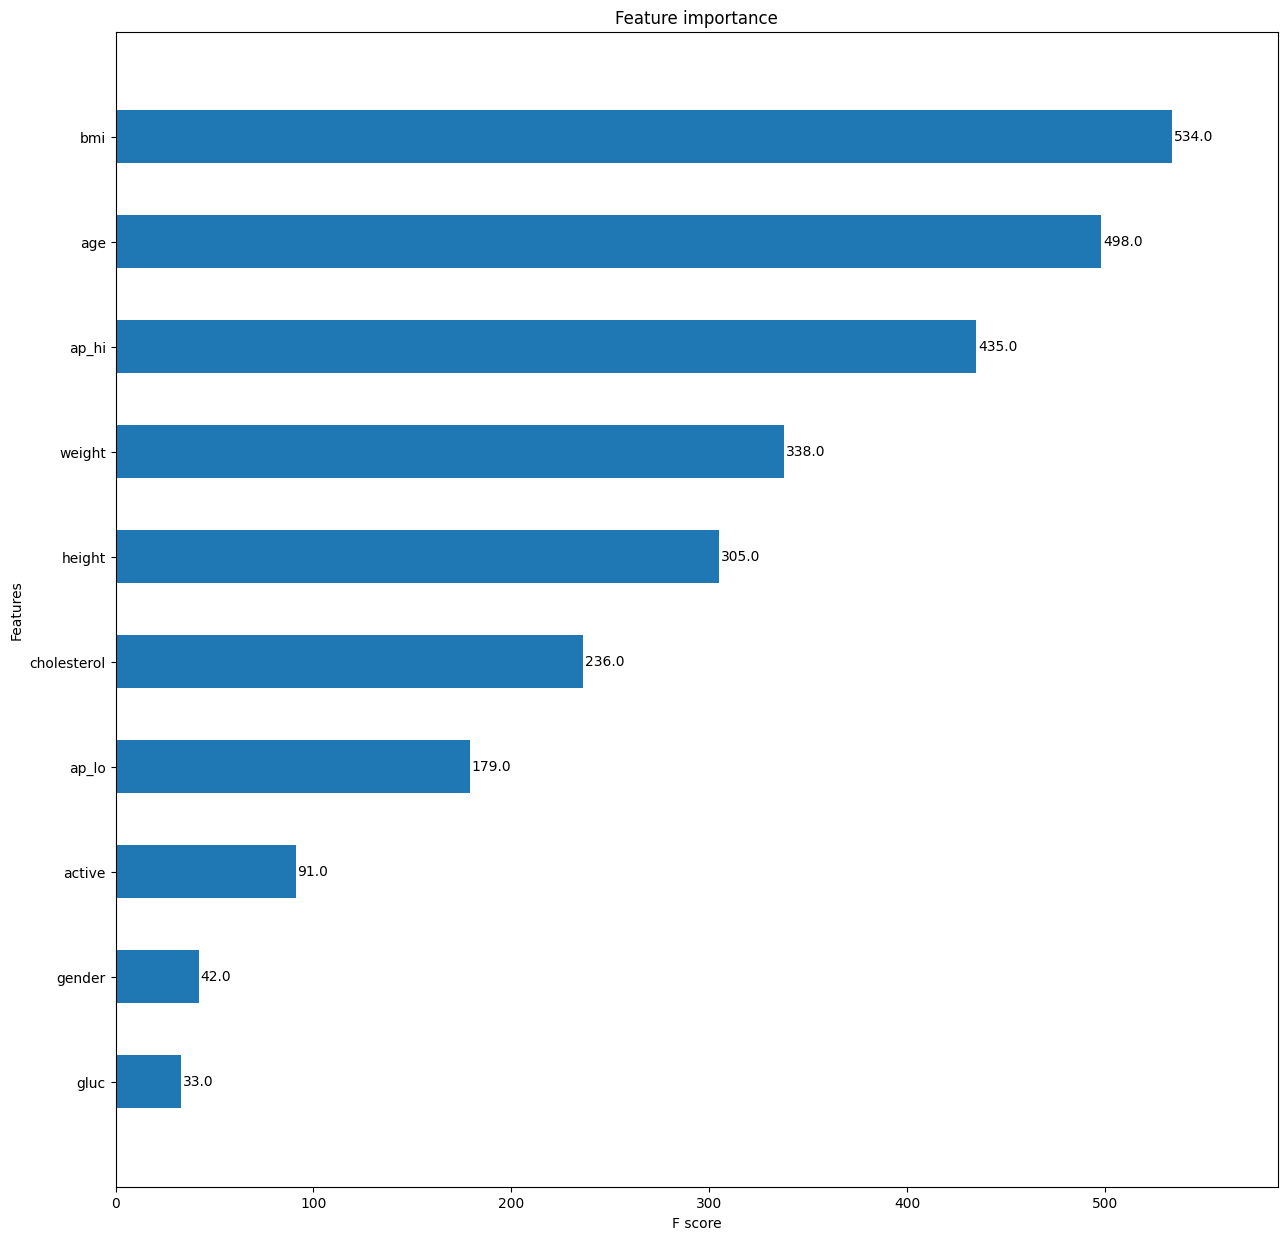

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Create a figure
fig = plt.figure(figsize=(15, 15))

# Add subplot
axes = fig.add_subplot(111)

# Plot feature importance using XGBoost's plot_importance function
plot_importance(XGB_Classifier, ax=axes, height=0.5)

# Remove grid from the plot
axes.grid(False)

# Display the plot
plt.show()
